# Прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель**: модель должна предсказывать, уйдет ли клиент или останется. В случае возможного ухода клиента, предложить особые условия обслуживания, которые позволит сохранить его (клиента) и сэкономить на привлечении нового клиента. В качестве основной метрики выбран ROC-AUC, оценка которой в идеале должна быть выше 0.85. На создание прототипа модели отведено 4 дня. Еще 4 дня на подготовку отчета.

**План работы:**
1. Изучить данные и сделать предобработку
    * Разобраться с пустыми строками
    * Соединить таблицы (можно после анализа данных)
2. Провести исследовательский анализ данных
3. Подобрать 3 модели (возможны изменения) и выбрать лучшую:
    * Логистическая регрессия
    * Метод случайного леса
    * KNN-метод
4. Сделать отчет по проведенной работе

## Предобработка и Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool

In [2]:
contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

### Контракты

In [3]:
display(contract_df.head())

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

**Целевой признак**: целевым признаком станет дата окончания договора `EndDate`. Таргет следует сделать бинарным.

In [4]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7043 entries, 0 to 7042

Data columns (total 8 columns):

 #   Column            Non-Null Count  Dtype  

---  ------            --------------  -----  

 0   customerID        7043 non-null   object 

 1   BeginDate         7043 non-null   object 

 2   EndDate           7043 non-null   object 

 3   Type              7043 non-null   object 

 4   PaperlessBilling  7043 non-null   object 

 5   PaymentMethod     7043 non-null   object 

 6   MonthlyCharges    7043 non-null   float64

 7   TotalCharges      7043 non-null   object 

dtypes: float64(1), object(7)

memory usage: 440.3+ KB


`TotalCharges`: необходимо поменять на тип данных `float64` <br>
`BeginDate` и `EndDate`: необходимо поменять на тип данных `datetime`

In [5]:
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d')

In [6]:
contract_df['BeginDate'].sort_values(ascending=True)

4513   2013-10-01
4610   2013-10-01
3439   2013-10-01
975    2013-11-01
3040   2013-11-01
          ...    
3331   2020-02-01
6670   2020-02-01
936    2020-02-01
3826   2020-02-01
6754   2020-02-01
Name: BeginDate, Length: 7043, dtype: datetime64[ns]

In [7]:
# Замена типа данных с str на float
# contract_df['TotalCharges'] = contract_df['TotalCharges'].astype('float64')

# ---> ValueError: could not convert string to float: ''

Ошибка. Надо посмотреть первые пять строк с пустыми значениями.

In [8]:
display(contract_df[contract_df['TotalCharges'] == ' '].head())

customerID  BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01      No  Two year              Yes   
753   3115-CZMZD 2020-02-01      No  Two year               No   
936   5709-LVOEQ 2020-02-01      No  Two year               No   
1082  4367-NUYAO 2020-02-01      No  Two year               No   
1340  1371-DWPAZ 2020-02-01      No  Two year               No   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55               
753                Mailed check           20.25               
936                Mailed check           80.85               
1082               Mailed check           25.75               
1340    Credit card (automatic)           56.05

По идее, если дата начала договора 2020-02-01, то можно понять, почему в колонке `TotalCharges` пустые строки — клиент еще не успел оплатить подписку и одного месяца. _Эти пробелы можно заполнить нулями._

In [9]:
# Замена пустых строк нулями
contract_df['TotalCharges'] = contract_df['TotalCharges'].replace(' ', 0.0)

In [10]:
# Замена типа данных с str на float
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype('float64')

С замененным типом данных и пропусками можно посмотреть на обновленную таблицу:

In [11]:
display(contract_df[contract_df['TotalCharges'] == 0.0].head())

customerID  BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01      No  Two year              Yes   
753   3115-CZMZD 2020-02-01      No  Two year               No   
936   5709-LVOEQ 2020-02-01      No  Two year               No   
1082  4367-NUYAO 2020-02-01      No  Two year               No   
1340  1371-DWPAZ 2020-02-01      No  Two year               No   

                  PaymentMethod  MonthlyCharges  TotalCharges  
488   Bank transfer (automatic)           52.55           0.0  
753                Mailed check           20.25           0.0  
936                Mailed check           80.85           0.0  
1082               Mailed check           25.75           0.0  
1340    Credit card (automatic)           56.05           0.0

In [12]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7043 entries, 0 to 7042

Data columns (total 8 columns):

 #   Column            Non-Null Count  Dtype         

---  ------            --------------  -----         

 0   customerID        7043 non-null   object        

 1   BeginDate         7043 non-null   datetime64[ns]

 2   EndDate           7043 non-null   object        

 3   Type              7043 non-null   object        

 4   PaperlessBilling  7043 non-null   object        

 5   PaymentMethod     7043 non-null   object        

 6   MonthlyCharges    7043 non-null   float64       

 7   TotalCharges      7043 non-null   float64       

dtypes: datetime64[ns](1), float64(2), object(5)

memory usage: 440.3+ KB


Типы данных стоят те, какие и должны быть.

In [13]:
print('Доля действующих договоров:',
      contract_df[contract_df['EndDate'] == 'No']['EndDate'].count() / contract_df['EndDate'].count())

Доля действующих договоров: 0.7346301292063041


In [14]:
display(contract_df.describe())

MonthlyCharges  TotalCharges
count     7043.000000   7043.000000
mean        64.761692   2279.734304
std         30.090047   2266.794470
min         18.250000      0.000000
25%         35.500000    398.550000
50%         70.350000   1394.550000
75%         89.850000   3786.600000
max        118.750000   8684.800000

**Ежемесячные платежи**: Медиана от среднего слабо отличаются, поэтому можно сказать, что выбросов практически нет.

**Суммарные платежи**: Здесь можно увидеть, как сильно отличается среднее в большую сторону от медианы. В этом признаке выбросы сильные.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


Text(0.5, 1.0, 'Total Charges')

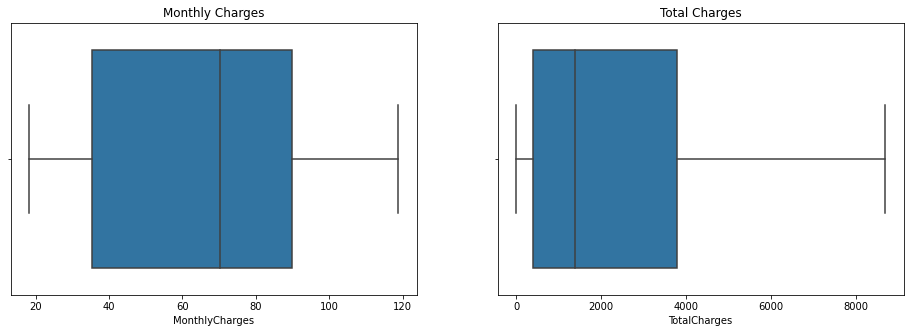

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
ax1 = sns.boxplot(contract_df['MonthlyCharges'], ax=ax[0]);
ax1.set_title('Monthly Charges')

ax2 = sns.boxplot(contract_df['TotalCharges'], ax=ax[1]);
ax2.set_title('Total Charges')

Выбросов нет, есть смещение медианы.

### Персональные данные

In [16]:
display(personal_df.head())

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [17]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7043 entries, 0 to 7042

Data columns (total 5 columns):

 #   Column         Non-Null Count  Dtype 

---  ------         --------------  ----- 

 0   customerID     7043 non-null   object

 1   gender         7043 non-null   object

 2   SeniorCitizen  7043 non-null   int64 

 3   Partner        7043 non-null   object

 4   Dependents     7043 non-null   object

dtypes: int64(1), object(4)

memory usage: 275.2+ KB


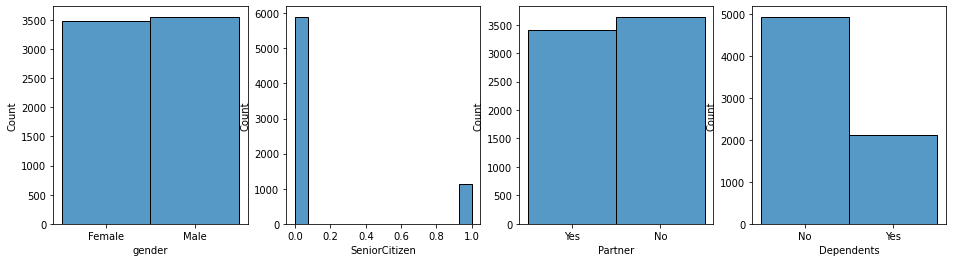

In [18]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16, 4))

ax0 = sns.histplot(personal_df['gender'], ax=ax[0])
ax1 = sns.histplot(personal_df['SeniorCitizen'], ax=ax[1])
ax2 = sns.histplot(personal_df['Partner'], ax=ax[2])
ax3 = sns.histplot(personal_df['Dependents'], ax=ax[3])

* У нас наблюдается сбалансированные признаки `gender` и `Partner`.
* А признаки `SeniorCitizen` и `Dependents` уже несбалансированы.
* Также нужно поменять название `gender` на `Gender`.

Признаки `SeniorCitizen` и `Dependets` можно попробовать сбалансировать.

In [19]:
personal_df = personal_df.rename({'gender': 'Gender'}, axis=1)

### Интернет услуги

In [20]:
internet_df.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [21]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 5517 entries, 0 to 5516

Data columns (total 8 columns):

 #   Column            Non-Null Count  Dtype 

---  ------            --------------  ----- 

 0   customerID        5517 non-null   object

 1   InternetService   5517 non-null   object

 2   OnlineSecurity    5517 non-null   object

 3   OnlineBackup      5517 non-null   object

 4   DeviceProtection  5517 non-null   object

 5   TechSupport       5517 non-null   object

 6   StreamingTV       5517 non-null   object

 7   StreamingMovies   5517 non-null   object

dtypes: object(8)

memory usage: 344.9+ KB


В этой таблице содержатся ID пользователей, у которых активна мининум одна услуга. Поэтому при присоединении этой таблицы к основной, пропуски заполним значениями `No`.

Посмотрим также на распределения классов.

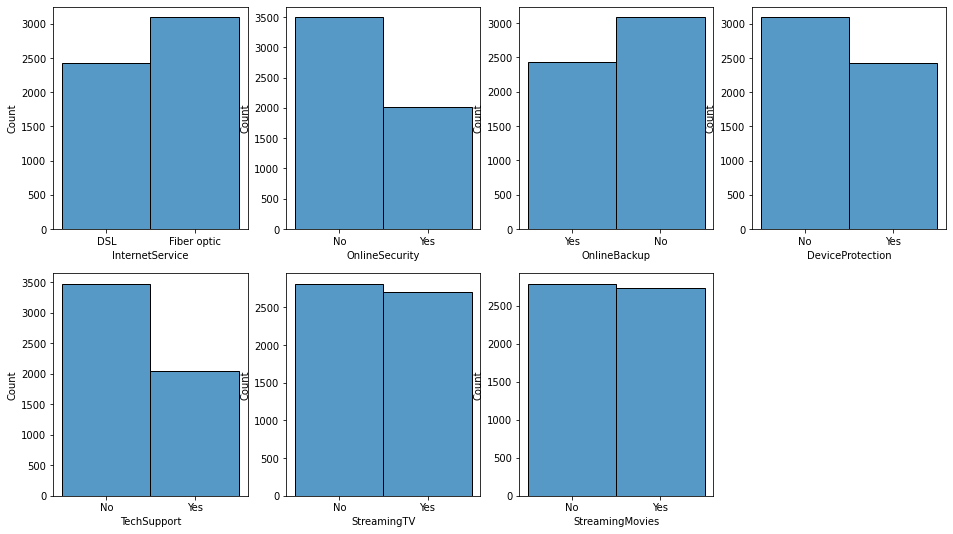

In [22]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 9))

ax0 = sns.histplot(internet_df['InternetService'], ax=ax[0, 0])
ax1 = sns.histplot(internet_df['OnlineSecurity'], ax=ax[0, 1])
ax2 = sns.histplot(internet_df['OnlineBackup'], ax=ax[0, 2])
ax3 = sns.histplot(internet_df['DeviceProtection'], ax=ax[0, 3])
ax4 = sns.histplot(internet_df['TechSupport'], ax=ax[1, 0])
ax5 = sns.histplot(internet_df['StreamingTV'], ax=ax[1, 1])
ax6 = sns.histplot(internet_df['StreamingMovies'], ax=ax[1, 2])

fig.delaxes(ax[1, 3])

* Здесь наблюдается дисбаланс классов на 50% у `OnlineSecurity` и `TechSupport`
* У оставшихся классов с этим более менее нормально.

### Подключение нескольких линий

In [23]:
phone_df.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [24]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 6361 entries, 0 to 6360

Data columns (total 2 columns):

 #   Column         Non-Null Count  Dtype 

---  ------         --------------  ----- 

 0   customerID     6361 non-null   object

 1   MultipleLines  6361 non-null   object

dtypes: object(2)

memory usage: 99.5+ KB


Логично предположить здесь то же самое (про заполнение пропусков значениями `No`). Но лучше проверить основную таблицу `contact_df` на наличие дубликатов в колонке `customerID`. Может в основной таблице одни и те же ID могли заключать несколько договоров в разные промежутки времени.

In [25]:
print('Кол-во дублей:', contract_df['customerID'].duplicated().sum())

Кол-во дублей: 0


Догадка не подтвердилась. Все ID пользователей разные.

### Соединение таблиц

In [26]:
data = contract_df.merge(personal_df, how='left', on='customerID')
data = data.merge(internet_df, how='left', on='customerID')
data = data.merge(phone_df, how='left', on='customerID')

In [27]:
data.head()

customerID  BeginDate              EndDate            Type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

   Gender  SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0  Female              0     Yes         No             DSL             No   
1    Male              0      No         No             DSL            Yes   
2    Male              0      No         No             DSL            Yes   
3    Male              0      No         No             DSL            Yes   
4  Female              0      No         No     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No          No          No              No   
1           No              Yes          No          No              No   
2          Yes               No          No          No              No   
3           No              Yes         Yes          No              No   
4           No               No          No          No              No   

  MultipleLines  
0           NaN  
1            No  
2            No  
3           NaN  
4            No

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 7043 entries, 0 to 7042

Data columns (total 20 columns):

 #   Column            Non-Null Count  Dtype         

---  ------            --------------  -----         

 0   customerID        7043 non-null   object        

 1   BeginDate         7043 non-null   datetime64[ns]

 2   EndDate           7043 non-null   object        

 3   Type              7043 non-null   object        

 4   PaperlessBilling  7043 non-null   object        

 5   PaymentMethod     7043 non-null   object        

 6   MonthlyCharges    7043 non-null   float64       

 7   TotalCharges      7043 non-null   float64       

 8   Gender            7043 non-null   object        

 9   SeniorCitizen     7043 non-null   int64         

 10  Partner           7043 non-null   object        

 11  Dependents        7043 non-null   object        

 12  InternetService   5517 non-null   object        

 13  OnlineSecurity    5517 non-null   object        

 14  Onlin

Теперь все пропуски заполним `No`, т.к. если ID клиента отсутствовало в той или иной таблице, то можно предположить, что теми услугами он не пользовался.

In [29]:
data = data.fillna('No')

In [30]:
print('Кол-во пропусков в датасете:', data.isna().sum())

Кол-во пропусков в датасете: customerID          0

BeginDate           0

EndDate             0

Type                0

PaperlessBilling    0

PaymentMethod       0

MonthlyCharges      0

TotalCharges        0

Gender              0

SeniorCitizen       0

Partner             0

Dependents          0

InternetService     0

OnlineSecurity      0

OnlineBackup        0

DeviceProtection    0

TechSupport         0

StreamingTV         0

StreamingMovies     0

MultipleLines       0

dtype: int64


**Теперь создадим бинарный таргет**

In [31]:
data['isChurn'] = list(map(lambda x: 0 if (x == 'No') else 1, data['EndDate']))

In [32]:
data['isChurn'].head()

0    0
1    0
2    1
3    0
4    1
Name: isChurn, dtype: int64

Отлично, теперь проверим признаки на мультиколлениарность и удалим лишние. Будем использовать VIF, для этого нужно перевести данные в численные типы. Используем разные виды кодирования.

Теперь создадим синтетический признак, который будет кол-во дней, сколько провел клиент с компанией.

In [33]:
data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')

data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

In [34]:
data['Days'] = (data['EndDate'] - data['BeginDate']).dt.days

### Проверка на мультиколлинеарность

In [35]:
data = data.drop(['BeginDate', 'EndDate', 'customerID'], axis=1)

Чтобы не множить дамми колонки через OHE, используем LabelEncoder для тех колонок, где всего два категориальных признака. LabelEncoder используется т.к. через него есть возможность передать одномерный массив, результатом которого можно будет датафрейм, а не вектор, как у OrdinalEncoder. А это удобно для дальнейшей работы.

In [36]:
print(data['Type'].unique())
print(data['InternetService'].unique())
print(data['PaymentMethod'].unique())

['Month-to-month' 'One year' 'Two year']

['DSL' 'Fiber optic' 'No']

['Electronic check' 'Mailed check' 'Bank transfer (automatic)'

 'Credit card (automatic)']


У колонки `Type` можно обнаружить порядок, поэтому для него тоже используем LabelEncoder.

In [37]:
features_ordinal = list(data.drop(['PaymentMethod', 'SeniorCitizen', 'InternetService', 'isChurn', 'MonthlyCharges',
                                   'TotalCharges'], axis=1).columns)

In [38]:
# Копиравоние датафрейма в новую переменную, чтобы потом была возможность работать со старым датафреймом
data_enc = data.copy()

In [39]:
for col in features_ordinal:
    data_enc[col] = LabelEncoder().fit_transform(data[col])
    
data_enc.head() 

Type  PaperlessBilling              PaymentMethod  MonthlyCharges  \
0     0                 1           Electronic check           29.85   
1     1                 0               Mailed check           56.95   
2     0                 1               Mailed check           53.85   
3     1                 0  Bank transfer (automatic)           42.30   
4     0                 1           Electronic check           70.70   

   TotalCharges  Gender  SeniorCitizen  Partner  Dependents InternetService  \
0         29.85       0              0        1           0             DSL   
1       1889.50       1              0        0           0             DSL   
2        108.15       1              0        0           0             DSL   
3       1840.75       1              0        0           0             DSL   
4        151.65       0              0        0           0     Fiber optic   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0               0             1                 0            0            0   
1               1             0                 1            0            0   
2               1             1                 0            0            0   
3               1             0                 1            1            0   
4               0             0                 0            0            0   

   StreamingMovies  MultipleLines  isChurn  Days  
0                0              0        0     2  
1                0              0        0    74  
2                0              0        1     3  
3                0              0        0    96  
4                0              0        1     3

In [40]:
data_dummies = pd.get_dummies(data[['PaymentMethod', 'InternetService']], drop_first=True)

data_dummies.head()

PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  InternetService_Fiber optic  InternetService_No  
0                           0                            0                   0  
1                           1                            0                   0  
2                           1                            0                   0  
3                           0                            0                   0  
4                           0                            1                   0

In [41]:
# Соединение таблиц по индексам
data_enc = data_enc.join(data_dummies)

# Удаление object колонок
data_enc = data_enc.drop(['PaymentMethod', 'InternetService'], axis=1)

In [42]:
data_enc.head()

Type  PaperlessBilling  MonthlyCharges  TotalCharges  Gender  \
0     0                 1           29.85         29.85       0   
1     1                 0           56.95       1889.50       1   
2     0                 1           53.85        108.15       1   
3     1                 0           42.30       1840.75       1   
4     0                 1           70.70        151.65       0   

   SeniorCitizen  Partner  Dependents  OnlineSecurity  OnlineBackup  ...  \
0              0        1           0               0             1  ...   
1              0        0           0               1             0  ...   
2              0        0           0               1             1  ...   
3              0        0           0               1             0  ...   
4              0        0           0               0             0  ...   

   StreamingTV  StreamingMovies  MultipleLines  isChurn  Days  \
0            0                0              0        0     2   
1            0                0              0        0    74   
2            0                0              0        1     3   
3            0                0              0        0    96   
4            0                0              0        1     3   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  InternetService_Fiber optic  InternetService_No  
0                           0                            0                   0  
1                           1                            0                   0  
2                           1                            0                   0  
3                           0                            0                   0  
4                           0                            1                   0  

[5 rows x 22 columns]

In [43]:
# Выделение нужных признаков в закодированном датафрейме
features = list(data_enc.drop(['isChurn'], axis=1).columns)

In [44]:
# подсчет vif для всех подаваемых признаков
def compute_vif(features):
    
    X = data_enc[features]
    X['intercept'] = 1
    
    # Создание датафрейма для хранения vif-значений
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable'] != 'intercept']
    return vif

In [45]:
compute_vif(features).sort_values('VIF', ascending=False)

Variable        VIF
2                          MonthlyCharges  35.307380
3                            TotalCharges  10.772273
19            InternetService_Fiber optic  10.094754
15                                   Days   7.557368
20                     InternetService_No   4.847748
0                                    Type   2.506311
12                            StreamingTV   2.451814
13                        StreamingMovies   2.435920
17         PaymentMethod_Electronic check   1.975474
14                          MultipleLines   1.919611
18             PaymentMethod_Mailed check   1.860371
11                            TechSupport   1.741989
10                       DeviceProtection   1.694122
8                          OnlineSecurity   1.678599
9                            OnlineBackup   1.638443
16  PaymentMethod_Credit card (automatic)   1.560660
6                                 Partner   1.462570
7                              Dependents   1.384230
1                        PaperlessBilling   1.208477
5                           SeniorCitizen   1.152858
4                                  Gender   1.001962

Можно увидеть сильную зависимость от признака `MonthlyCharges`. Будем удалять последовательно признаки, начиная с этого.

In [46]:
features.remove('MonthlyCharges')

compute_vif(features).sort_values('VIF', ascending=False)

/tmp/ipykernel_49/1579707019.py:5: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X['intercept'] = 1


Variable        VIF
2                            TotalCharges  10.219714
14                                   Days   7.193266
0                                    Type   2.504028
19                     InternetService_No   2.494227
18            InternetService_Fiber optic   2.262436
16         PaymentMethod_Electronic check   1.974544
17             PaymentMethod_Mailed check   1.859686
12                        StreamingMovies   1.724627
11                            StreamingTV   1.713751
15  PaymentMethod_Credit card (automatic)   1.560610
10                            TechSupport   1.541646
9                        DeviceProtection   1.540362
7                          OnlineSecurity   1.480227
8                            OnlineBackup   1.471273
5                                 Partner   1.462569
13                          MultipleLines   1.388355
6                              Dependents   1.384021
1                        PaperlessBilling   1.208377
4                           SeniorCitizen   1.150941
3                                  Gender   1.001957

In [47]:
features.remove('TotalCharges')

In [48]:
compute_vif(features).sort_values('VIF', ascending=False)

/tmp/ipykernel_49/1579707019.py:5: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X['intercept'] = 1


Variable       VIF
13                                   Days  2.759208
0                                    Type  2.488154
18                     InternetService_No  2.477014
15         PaymentMethod_Electronic check  1.971259
16             PaymentMethod_Mailed check  1.840883
17            InternetService_Fiber optic  1.736077
11                        StreamingMovies  1.630669
10                            StreamingTV  1.624289
14  PaymentMethod_Credit card (automatic)  1.560295
9                             TechSupport  1.479218
8                        DeviceProtection  1.478855
4                                 Partner  1.462391
6                          OnlineSecurity  1.412004
5                              Dependents  1.383500
7                            OnlineBackup  1.379688
12                          MultipleLines  1.331253
1                        PaperlessBilling  1.208325
3                           SeniorCitizen  1.150722
2                                  Gender  1.001711

Дальше удалять признаки не нужно, т.к. никакие из них не превышают значения `5`. Можно предположить, что утечки данных не должно произойти.

In [49]:
data_enc_linear = data_enc.drop(['MonthlyCharges', 'TotalCharges'], axis=1)

<AxesSubplot:xlabel='isChurn', ylabel='Count'>

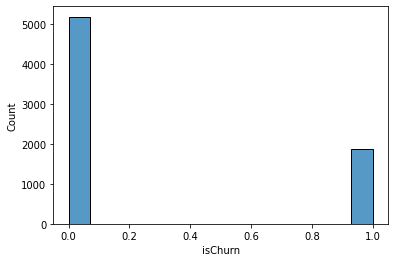

In [50]:
sns.histplot(data['isChurn'])

## Создание прототипа модели

### Разделение выборок

In [51]:
# Выделение признаков и таргета
X = data_enc_linear.drop(['isChurn'], axis=1)
y = data_enc_linear['isChurn']

# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=190922)

Проверим, как разделили данные.

In [52]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5634, 19)

(1409, 19)

(5634,)

(1409,)


### Logistic Regression

In [53]:
log_reg = LogisticRegression()

In [54]:
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
solver = ['liblinear']

In [55]:
parameters = dict(C=C,
                  penalty=penalty,
                  solver=solver,
                  random_state=[190922],
                  class_weight=['balanced'])

In [56]:
gs = GridSearchCV(log_reg, parameters,
                  cv=3,
                  verbose=2,
                 scoring='roc_auc')

In [57]:
print(log_reg.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [58]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits

[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=190922, solver=liblinear; total time=   0.0s

[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=190922, solver=liblinear; total time=   0.1s

[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=190922, solver=liblinear; total time=   0.1s

[CV] END C=0.0001, class_weight=balanced, penalty=l2, random_state=190922, solver=liblinear; total time=   0.1s

[CV] END C=0.0001, class_weight=balanced, penalty=l2, random_state=190922, solver=liblinear; total time=   0.1s

[CV] END C=0.0001, class_weight=balanced, penalty=l2, random_state=190922, solver=liblinear; total time=   0.1s

[CV] END C=0.00014563484775012445, class_weight=balanced, penalty=l1, random_state=190922, solver=liblinear; total time=   0.0s

[CV] END C=0.00014563484775012445, class_weight=balanced, penalty=l1, random_state=190922, solver=liblinear; total time=   0.1s



GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.685113...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'class_weight': ['balanced'], 'penalty': ['l1', 'l2'],
                         'random_state': [190922], 'solver': ['liblinear']},
             scoring='roc_auc', verbose=2)

In [59]:
print('Best Penalty:', gs.best_estimator_.get_params()['penalty'])
print('Best C:', gs.best_estimator_.get_params()['C'])
print('Best score: ', gs.best_score_)

Best Penalty: l2

Best C: 0.019306977288832496

Best score:  0.8458297358116109


Тоже самое на нормализованных данных (`TotalCharged`)

In [60]:
data_normalized = data_enc_linear.copy()

x = X_train['Days'].values # вернет numpy массив
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(x.reshape(-1, 1))
X_all = data_normalized['Days'].values
data_normalized['Days'] = min_max_scaler.transform(X_all.reshape(-1, 1))

Проверим результат.

In [61]:
data_normalized.head()

Type  PaperlessBilling  Gender  SeniorCitizen  Partner  Dependents  \
0     0                 1       0              0        1           0   
1     1                 0       1              0        0           0   
2     0                 1       1              0        0           0   
3     1                 0       1              0        0           0   
4     0                 1       0              0        0           0   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0               0             1                 0            0            0   
1               1             0                 1            0            0   
2               1             1                 0            0            0   
3               1             0                 1            1            0   
4               0             0                 0            0            0   

   StreamingMovies  MultipleLines  isChurn      Days  \
0                0              0        0  0.012903   
1                0              0        0  0.477419   
2                0              0        1  0.019355   
3                0              0        0  0.619355   
4                0              0        1  0.019355   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  InternetService_Fiber optic  InternetService_No  
0                           0                            0                   0  
1                           1                            0                   0  
2                           1                            0                   0  
3                           0                            0                   0  
4                           0                            1                   0

In [62]:
# Выделение признаков и таргета нормализированных данных
X = data_normalized.drop(['isChurn'], axis=1)
y = data_normalized['isChurn']

# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=190922)

In [63]:
gs = GridSearchCV(log_reg, parameters,
                  cv=3,
                  verbose=2,
                 scoring='roc_auc')

gs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits

[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=190922, solver=liblinear; total time=   0.0s

[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=190922, solver=liblinear; total time=   0.0s

[CV] END C=0.0001, class_weight=balanced, penalty=l1, random_state=190922, solver=liblinear; total time=   0.1s

[CV] END C=0.0001, class_weight=balanced, penalty=l2, random_state=190922, solver=liblinear; total time=   0.1s

[CV] END C=0.0001, class_weight=balanced, penalty=l2, random_state=190922, solver=liblinear; total time=   0.2s

[CV] END C=0.0001, class_weight=balanced, penalty=l2, random_state=190922, solver=liblinear; total time=   0.1s

[CV] END C=0.00014563484775012445, class_weight=balanced, penalty=l1, random_state=190922, solver=liblinear; total time=   0.1s

[CV] END C=0.00014563484775012445, class_weight=balanced, penalty=l1, random_state=190922, solver=liblinear; total time=   0.1s



GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.685113...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'class_weight': ['balanced'], 'penalty': ['l1', 'l2'],
                         'random_state': [190922], 'solver': ['liblinear']},
             scoring='roc_auc', verbose=2)

In [64]:
print('Лучший Penalty на нормализованных данных:', gs.best_estimator_.get_params()['penalty'])
print('Лучший C:', gs.best_estimator_.get_params()['C'])
print('Лучшая оценка: ', gs.best_score_)

Лучший Penalty на нормализованных данных: l1

Лучший C: 0.12648552168552957

Лучшая оценка:  0.8454946416951317


In [65]:
columns = ['ROC-AUC-SCORE']
indexes = ['Нормализованные данные', 'Обычные данные']
data = [0.8454946416951317, 0.8458297358116109]

lr_cv = pd.DataFrame(data=data, index=indexes, columns=columns)

lr_cv

ROC-AUC-SCORE
Нормализованные данные       0.845495
Обычные данные               0.845830

Как можно увидеть, результаты на кроссвалидации при обычных данных чуть лучше, чем на нормализованных.

### CatBoostClassifier

In [66]:
cb = CatBoostClassifier()

In [67]:
# Выделение признаков и таргета
X = data_enc.drop(['isChurn'], axis=1)
y = data_enc['isChurn']

# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=190922)

In [68]:
parameters = {'depth': [1, 3, 5, 7, 10, 13, 15, 17, 20],
             'learning_rate': [.1, .01, .02, .035],
             'iterations': [90, 100, 120, 140, 150, 170, 200],
             'random_state': [190922],
             'loss_function': ['Logloss']}

In [69]:
grid_cb = GridSearchCV(estimator=cb, param_grid =parameters, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_cb.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits

0:	learn: 0.6572967	total: 46.4ms	remaining: 4.13s

1:	learn: 0.6147176	total: 47.2ms	remaining: 2.08s

2:	learn: 0.5824061	total: 48ms	remaining: 1.39s

3:	learn: 0.5657496	total: 48.6ms	remaining: 1.04s

4:	learn: 0.5446269	total: 49.1ms	remaining: 835ms

5:	learn: 0.5308071	total: 49.7ms	remaining: 695ms

6:	learn: 0.5199187	total: 50.2ms	remaining: 595ms

7:	learn: 0.5110285	total: 50.8ms	remaining: 521ms

8:	learn: 0.5032437	total: 51.3ms	remaining: 462ms

9:	learn: 0.4928744	total: 51.9ms	remaining: 415ms

10:	learn: 0.4868458	total: 52.6ms	remaining: 378ms

11:	learn: 0.4808763	total: 53.6ms	remaining: 348ms

12:	learn: 0.4765874	total: 54.1ms	remaining: 320ms

13:	learn: 0.4721912	total: 54.7ms	remaining: 297ms

14:	learn: 0.4666239	total: 55.4ms	remaining: 277ms

15:	learn: 0.4632568	total: 56.1ms	remaining: 260ms

16:	learn: 0.4606052	total: 56.7ms	remaining: 243ms

17:	learn: 0.4574583	total: 57.2ms	remaining: 2

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=90, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=90, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=90, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=90, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=90, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=90, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=90, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=90, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=100, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=100, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=100, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=100, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=100, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=100, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=100, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=100, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=100, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=100, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=100, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=100, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=120, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=120, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=120, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=120, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=120, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=120, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=120, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=120, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=120, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=120, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=120, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=120, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=140, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=140, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=140, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=140, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=140, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=140, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=140, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=140, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=140, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=140, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=140, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=140, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=150, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=150, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=150, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=150, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=150, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=150, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=150, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=150, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=150, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=150, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=150, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=150, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=170, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=170, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=170, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=170, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=170, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=170, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=170, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=170, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=170, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=170, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=170, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=170, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=200, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=200, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=200, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=200, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=200, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=200, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=200, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=200, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=200, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=200, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=17, iterations=200, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=17, iterations=200, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=90, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=90, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=90, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=90, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=90, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=90, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=90, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=90, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=90, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=90, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=90, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=90, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=100, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=100, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=100, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=100, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=100, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=100, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=100, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=100, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=100, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=100, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=100, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=100, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=120, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=120, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=120, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=120, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=120, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=120, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=120, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=120, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=120, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=120, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=120, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=120, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=140, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=140, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=140, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=140, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=140, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=140, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=140, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=140, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=140, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=140, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=140, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=140, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=150, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=150, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=150, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=150, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=150, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=150, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=150, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=150, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=150, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=150, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=150, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=150, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=170, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=170, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=170, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=170, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=170, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=170, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=170, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=170, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=170, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=170, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=170, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=170, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=200, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=200, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=200, learning_rate=0.1, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=200, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=200, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=200, learning_rate=0.01, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=200, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=200, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=200, learning_rate=0.02, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=200, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

[CV] END depth=20, iterations=200, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 

Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 4716, in fit

    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit

    train_params = self._prepare_train_params(

  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params

    _check_train_params(params)

  File "_catboost.pyx", line 5839, in _catboost._check_train_params

  File "_catboost

[CV] END depth=20, iterations=200, learning_rate=0.035, loss_function=Logloss, random_state=190922; total time=   0.0s

0:	learn: 0.6291742	total: 1.72ms	remaining: 342ms

1:	learn: 0.5774066	total: 3.66ms	remaining: 362ms

2:	learn: 0.5411546	total: 5.4ms	remaining: 354ms

3:	learn: 0.5119413	total: 7.09ms	remaining: 348ms

4:	learn: 0.4883399	total: 8.82ms	remaining: 344ms

5:	learn: 0.4712986	total: 10.5ms	remaining: 341ms

6:	learn: 0.4559732	total: 12.2ms	remaining: 337ms

7:	learn: 0.4464307	total: 13.8ms	remaining: 330ms

8:	learn: 0.4349373	total: 15.4ms	remaining: 327ms

9:	learn: 0.4277356	total: 17ms	remaining: 323ms

10:	learn: 0.4198815	total: 18.7ms	remaining: 321ms

11:	learn: 0.4147972	total: 20.2ms	remaining: 316ms

12:	learn: 0.4104254	total: 21.7ms	remaining: 313ms

13:	learn: 0.4041255	total: 23.4ms	remaining: 311ms

14:	learn: 0.4003460	total: 25.1ms	remaining: 310ms

15:	learn: 0.3960022	total: 26.5ms	remaining: 305ms

16:	learn: 0.3931963	total: 28ms	remaining: 3

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fce9e65fb50>,
             n_jobs=-1,
             param_grid={'depth': [1, 3, 5, 7, 10, 13, 15, 17, 20],
                         'iterations': [90, 100, 120, 140, 150, 170, 200],
                         'learning_rate': [0.1, 0.01, 0.02, 0.035],
                         'loss_function': ['Logloss'],
                         'random_state': [190922]},
             scoring='roc_auc', verbose=2)

In [70]:
print(" Результаты CatBoostClassifier " )
print("\n Лучшая оценка из всех параметров:\n", grid_cb.best_score_)
print("\n Лучшие параметры из всех искомых параметров:\n", grid_cb.best_params_)

 Результаты CatBoostClassifier 



 Лучшая оценка из всех параметров:

 0.8841947545282228



 Лучшие параметры из всех искомых параметров:

 {'depth': 5, 'iterations': 200, 'learning_rate': 0.1, 'loss_function': 'Logloss', 'random_state': 190922}


### KNN метод

In [71]:
model = KNeighborsClassifier()

In [72]:
parameters = {'n_neighbors': [3, 5, 7, 10],
             'weights': ['uniform', 'distance'],
             'p': [1, 2]}

In [73]:
# Выделение признаков и таргета
X = data_enc_linear.drop(['isChurn'], axis=1)
y = data_enc_linear['isChurn']

# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=190922)

In [74]:
model_cv = GridSearchCV(estimator=model, param_grid=parameters, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits

[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.1s

[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.1s

[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.1s

[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.1s

[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.1s

[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.1s

[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.3s

[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.3s

[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.3s

[CV] END ...............n_neighbors=3, p=2, weights=distance; total time=   0.3s

[CV] END ...............n_neighbors=3, p=2, weights=distance; total time=   0.3s

[CV] END ...............n_neighbors=

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=2)

In [75]:
print(" Результаты KNN " )
print("\n Лучшая оценка из всех параметров:\n", model_cv.best_score_)
print("\n Лучшие параметры из всех искомых параметров:\n", model_cv.best_params_)

 Результаты KNN 



 Лучшая оценка из всех параметров:

 0.8531185164641819



 Лучшие параметры из всех искомых параметров:

 {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


### Метод случайного леса

In [76]:
rfc = RandomForestClassifier()

In [77]:
parameters = {'n_estimators': [10, 30, 50, 70, 90, 100],
             'max_depth': [10, 15, 20],
             'random_state': [190922]}

In [78]:
# Выделение признаков и таргета
X = data_enc.drop(['isChurn'], axis=1)
y = data_enc['isChurn']

# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=190922)

In [79]:
rfc_cv = GridSearchCV(estimator=rfc, param_grid=parameters, n_jobs=-1, verbose=2, scoring='roc_auc')
rfc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

[CV] END .max_depth=10, n_estimators=10, random_state=190922; total time=   0.0s

[CV] END .max_depth=10, n_estimators=10, random_state=190922; total time=   0.0s

[CV] END .max_depth=10, n_estimators=10, random_state=190922; total time=   0.0s

[CV] END .max_depth=10, n_estimators=10, random_state=190922; total time=   0.0s

[CV] END .max_depth=10, n_estimators=10, random_state=190922; total time=   0.0s

[CV] END .max_depth=10, n_estimators=30, random_state=190922; total time=   0.1s

[CV] END .max_depth=10, n_estimators=30, random_state=190922; total time=   0.1s

[CV] END .max_depth=10, n_estimators=30, random_state=190922; total time=   0.1s

[CV] END .max_depth=10, n_estimators=30, random_state=190922; total time=   0.1s

[CV] END .max_depth=10, n_estimators=30, random_state=190922; total time=   0.1s

[CV] END .max_depth=10, n_estimators=50, random_state=190922; total time=   0.1s

[CV] END .max_depth=10, n_estimators

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [10, 30, 50, 70, 90, 100],
                         'random_state': [190922]},
             scoring='roc_auc', verbose=2)

In [80]:
print(" Результаты случайного леса " )
print("\n Лучшая оценка из всех параметров:\n", rfc_cv.best_score_)
print("\n Лучшие параметры из всех искомых параметров:\n", rfc_cv.best_params_)

 Результаты случайного леса 



 Лучшая оценка из всех параметров:

 0.8581262210692862



 Лучшие параметры из всех искомых параметров:

 {'max_depth': 10, 'n_estimators': 100, 'random_state': 190922}


## Тестирование модели

Из всех моделей, лучшую оценку на кроссвалидации сделала модель CatBoostClassifier. Её проверим на тестовой.

In [81]:
cb = CatBoostClassifier(depth=5, iterations=200, learning_rate=.1, random_state=190922)

cb.fit(X_train, y_train)

0:	learn: 0.6291742	total: 1.69ms	remaining: 337ms

1:	learn: 0.5774066	total: 3.53ms	remaining: 349ms

2:	learn: 0.5411546	total: 5.1ms	remaining: 335ms

3:	learn: 0.5119413	total: 6.79ms	remaining: 332ms

4:	learn: 0.4883399	total: 8.39ms	remaining: 327ms

5:	learn: 0.4712986	total: 10.2ms	remaining: 329ms

6:	learn: 0.4559732	total: 11.8ms	remaining: 325ms

7:	learn: 0.4464307	total: 13.4ms	remaining: 322ms

8:	learn: 0.4349373	total: 14.9ms	remaining: 316ms

9:	learn: 0.4277356	total: 16.5ms	remaining: 314ms

10:	learn: 0.4198815	total: 18.2ms	remaining: 313ms

11:	learn: 0.4147972	total: 19.8ms	remaining: 310ms

12:	learn: 0.4104254	total: 21.3ms	remaining: 306ms

13:	learn: 0.4041255	total: 22.9ms	remaining: 304ms

14:	learn: 0.4003460	total: 24.4ms	remaining: 301ms

15:	learn: 0.3960022	total: 26ms	remaining: 299ms

16:	learn: 0.3931963	total: 27.6ms	remaining: 297ms

17:	learn: 0.3910840	total: 29.4ms	remaining: 297ms

18:	learn: 0.3890350	total: 31ms	remaining: 296ms

19:	lear

In [82]:
predict_proba = cb.predict_proba(X_test)[:, 1]

print('ROC-AUC:', roc_auc_score(y_test, predict_proba))

ROC-AUC: 0.8960783456477068


In [83]:
predictions = cb.predict(X_test)

print('Accuracy:', accuracy_score(y_test, predictions))

Accuracy: 0.8449254790631654


Нарисуем ROC-кривую.

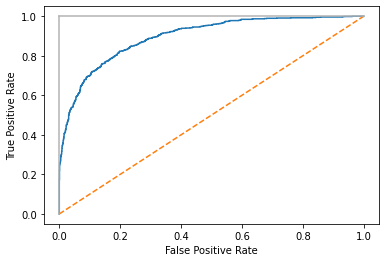

In [84]:
fpr, tpr, _ = roc_curve(y_test, predict_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Можно увидеть, что модель предсказывает не случайно.

Удалось найти модель и подобрать для нее гиперпараметры, которая достигает необходимых метрик.

Итоговая метрика ROC-AUC на тестовой выборке: 0.8960783456477068

<AxesSubplot:title={'center':'Важность признаков'}>

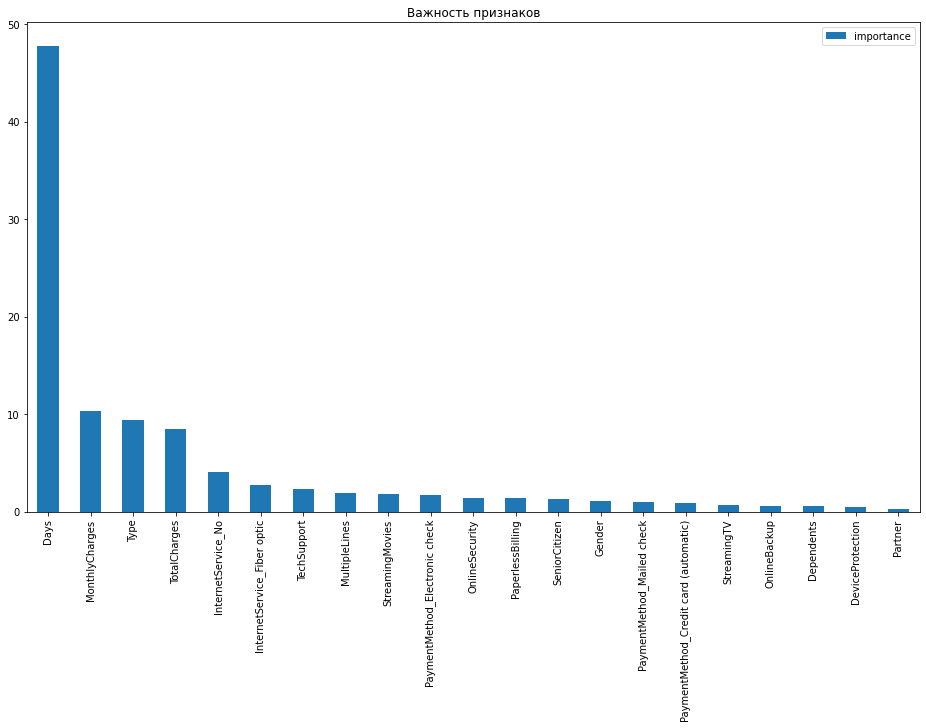

In [85]:
features_importance = cb.get_feature_importance()
# features_importance = sorted(features_importance, reverse=True)

importance = pd.DataFrame(data=features_importance, index=list(X_test.columns), columns=['importance'])

importance.sort_values(by='importance', ascending=False).plot(kind='bar',
                                                              figsize=(16,9),
                                                              title='Важность признаков')

Можно увидеть, что для CatBoost'a есть 4 самых важных признака: кол-во дней, тип подлючения, подключения оптического кабеля и отсутствие интернет служб.

In [86]:
y_pred = cb.predict(X_test)

Text(0.5, 1.05, 'Матрица ошибок')

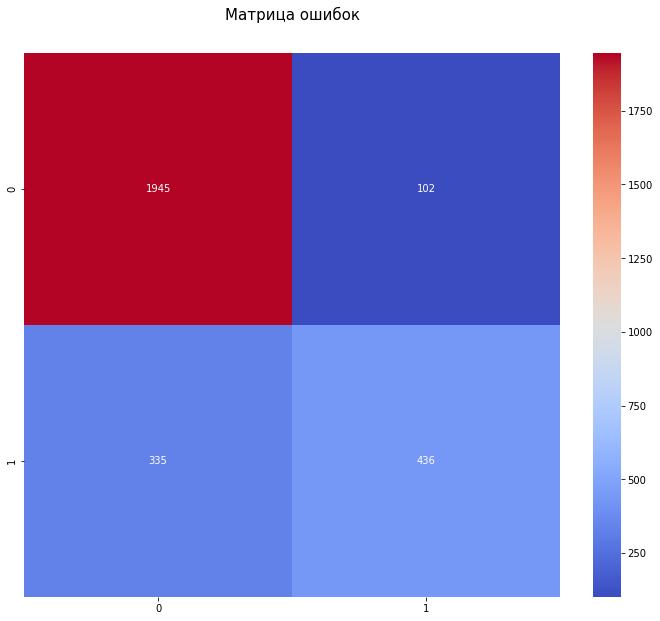

In [87]:
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="coolwarm", fmt='3.0f')
plt.title('Матрица ошибок', y=1.05, size=15)

Модель отлично справляется с предсказанием отрицательного класса (клиент не уйдёт), но с предсказанием ухода клиента делает частые ошибки, но и не угадывает. Модель также чаще предсказывает отрицательный класс, что необходимо для бизнеса: определить, уйдет ли клиент.

## Отчет

Были выполнены практически все пункты плана, в том числе была добавлена еще модель для исследования: CatBoostClassifier. К сожалению, в задуманные сроки не удалось уложиться, т.к. возникали ошибки по ходу написания кода, которые надо было исправлять (об этом ниже).

Главная трудность возникала при написании модели CatBoostClassifier, где не получилось подать "грязные" данные на вход из-за `ValueError isChurn is not in List`. Через несколько попыток исправлений решила это обойти с помощью закодированных данных.

Ключевые шаги в работе:
* Изучить таблицы с данными по отдельности
* Поменять типы данных и разобраться с пропусками
* Выделить таргет и создать синтетический признак
* Соединить таблицы
* Провести исследовательский анализ данных
* Провести анализ влияния факторов через аналитический метод (VIF)
* Поиск наилучшей модели
* Тестирование лучшей модели

**Как проходила предобработка данных?**
1. Вывела все таблицы и изучила их структуру
2. Перевела строки с датами в тип данных `datetime`, чтобы можно было с ними работать как с числами
3. При попытке изменении типа данных в колонке общего дохода от клиента, было обнаружено, что датасет собран на момент 2020-02-01
4. В следствие этого пропуски в колонке общего дохода от клиента были заполнены нулями, т.к. клиент не успел еще внести "тотал"
5. Далее создала синтетический признак на основе двух имеющихся: дата начала договора и дата его окончания. Сделано это для выведени "лояльности" клиента. Ведь чем дольше он с компанией, тем меньше шансов его ухода.
6. Соединила таблицы.
7. Пропуски в новом датафрейме заполнила `No`, т.к. отсутствие ID клиента в той или иной таблице подразумевает отсутствие и самой услуги у клиента.
8. Удалила признаки с датами для избежание утечки данных (особенно дата окончания договора).
9. Провела проверку на мультиколлинеарность с помощью VIF, в результате которого было удалено два признака. Данная проверка проводилась для работы с линейными моделями и избежания сильных зависимостей.
10. Кодировала категориальные признаки сочетая два способа: OneHotEncoding и LabelEncoding (в ретроспективе понимаю, что для некоторых признаков надо было сделать OHE, а не LabelEncoding, например в колонке `Gender`)

Для обучения модели использовалась часть старых признаков и два новых. Удалены временные признаки, т.к. это не анализ временных рядов и можно получить утечку данных. Добавлен таргет из даты окончания договора - ушел клиент или нет? И добавлено кол-во дней активного договора из обеих дат (начала и окончания договора), показывающий лояльность клиента.

<AxesSubplot:title={'center':'Важность признаков'}>

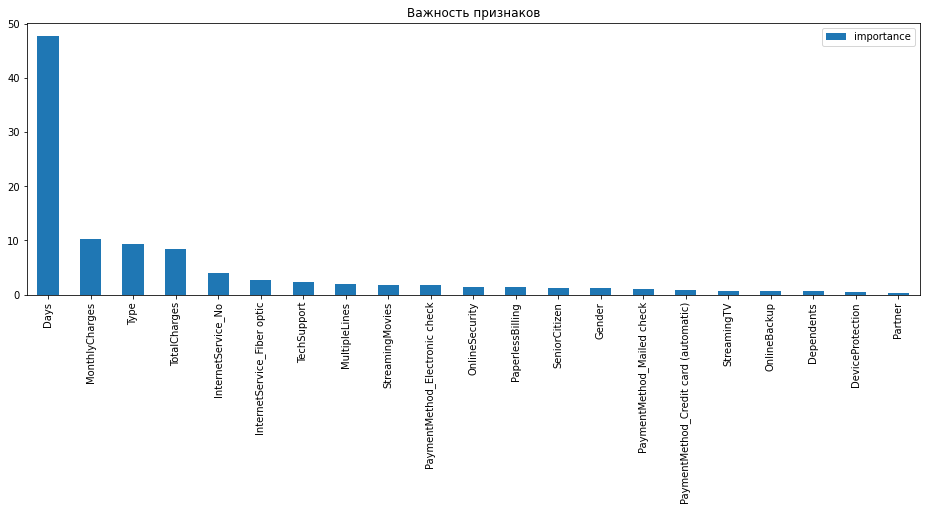

In [88]:
importance.sort_values(by='importance', ascending=False).plot(kind='bar',
                                                              figsize=(16,5),
                                                              title='Важность признаков')

После анализа важности признаков можно сделать вывод о ненадобности последних пяти признаков: наличие партнера, наличие иждивенцев, две услуги и способ оплаты через почту. Если бизнес будет использовать модель в будущем, то эти данные не нужно собирать для предсказывания ухода от компании.

In [91]:
indexes = ['LogisticRegression', 'RandomForestClassifier', 'KNN', 'CatBoostClassifier']
data = [0.845830, 0.8581262210692862, 0.8531185164641819, 0.8960783456477068]

pivot = pd.DataFrame(data=data, index=indexes, columns=['CrossValidation Score'])

Сравнение моделей на кросс-валидации ниже.

In [92]:
pivot.sort_values(by='CrossValidation Score', ascending=False)

CrossValidation Score
CatBoostClassifier                   0.896078
RandomForestClassifier               0.858126
KNN                                  0.853119
LogisticRegression                   0.845830

В качестве итоговой модели выбран CatBoostClassifier.

**Оценки итоговой модели** <br>

Accuracy: 0.844925 <br>
ROC-AUC: 0.896078